In [11]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "INTC"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime.now().date()
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,INTC,26.96,27.06,26.62,27.05,32165978.0,122840.0,26.88
2016-01-05 05:00:00+00:00,INTC,27.02,27.05,26.68,26.92,17905707.0,87505.0,26.85
2016-01-06 05:00:00+00:00,INTC,26.46,26.67,26.10,26.32,26939523.0,121984.0,26.39
2016-01-07 05:00:00+00:00,INTC,25.68,26.26,25.33,25.33,41368839.0,163862.0,25.63
2016-01-08 05:00:00+00:00,INTC,25.53,25.64,25.01,25.07,32404640.0,142641.0,25.31


<Axes: xlabel='timestamp'>

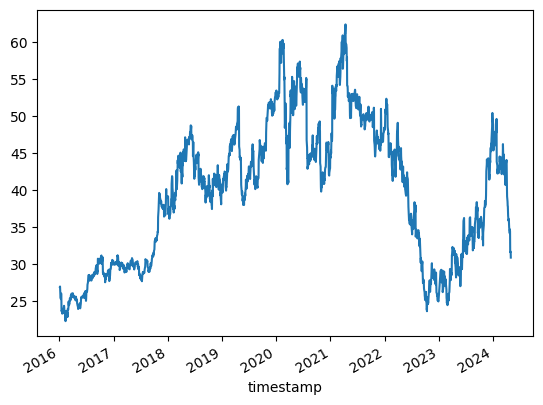

In [12]:
data["open"].plot()

In [13]:
delta = data["open"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta<0,0)
win_size = 20
avg_gain = gain.rolling(win_size).mean()
avg_loss = loss.rolling(win_size).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
rsi.tail()

timestamp
2024-04-24 04:00:00+00:00    23.257576
2024-04-25 04:00:00+00:00    19.209915
2024-04-26 04:00:00+00:00     8.776780
2024-04-29 04:00:00+00:00     5.848787
2024-04-30 04:00:00+00:00     5.666897
Name: open, dtype: float64

<Axes: xlabel='timestamp'>

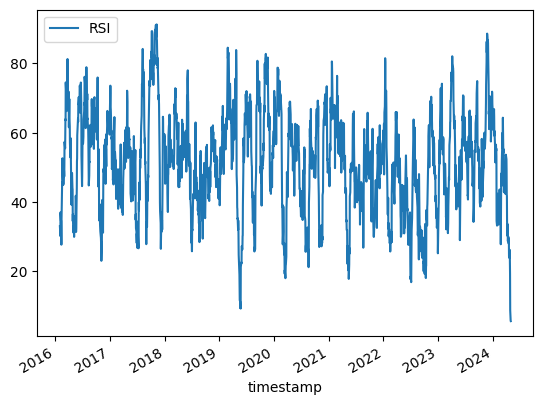

In [14]:
pd.DataFrame({"RSI":rsi}, index=data.index).plot()

In [15]:
split_prc = 0.3
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

2095 628 1467


In [20]:
from numpy import ndarray
from pandas import DataFrame

from cira.strategy import back_test
from tqdm import tqdm


class RelativeStrengthIndexStartegy(cira.strategy.Strategy):

    def __init__(self, sma_window = 20, risk=0.1) -> None:
        super().__init__(name="RSI")
        self.sma_window = sma_window
        self.risk = risk 
        self.allocation = []

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float)-> ndarray: 
        _feature_data = feature_data.copy()
        delta = _feature_data["open"].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta<0,0)
        avg_gain = gain.rolling(self.sma_window).mean()
        avg_loss = loss.rolling(self.sma_window).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        _all = np.array([0])
        if len(_feature_data) < self.sma_window:
            pass 

        elif rsi.iloc[-1] < 40: # BUY 
            _all = np.array([int((cash*self.risk))//prices.iloc[-1].values[0]])

        else: # SELL
            _all = np.array([-1*portfolio[-1]*self.risk])

        if rsi.iloc[-1] > 60: # HOLD 
            _all = np.array([0])

        self.allocation.append(_all)
        return _all.astype(float)
                


    def fit(self, featrue_data: DataFrame, sma_windows = [10, 20, 30], risk_lvls=[0.1, 0.2, 0.3], capital=10_000):
        best_prof = 0 
        best_sma = 20
        risk = 0.1
        for r in tqdm(risk_lvls):
            for sma_w in sma_windows: 
                strat = RelativeStrengthIndexStartegy(sma_w, risk=r)
                bt = back_test(strat, featrue_data, featrue_data["close"].to_frame(), capital) 
                prof = bt[strat.name].values[-1] - capital 
                if prof > best_prof: 
                    best_sma = sma_w
                    best_prof = prof
                    risk = r

        print(f"sma:{best_sma} @ risk {risk}, portfolio change {best_prof:.2f}$")

        self.sma_window = best_sma
        self.risk = risk
        return self
                


In [21]:
strat = RelativeStrengthIndexStartegy()
start = strat.fit(train_data, sma_windows=list(range(10,60,10)), risk_lvls=[i/10 for i in range(1,4)], capital=100_000)

100%|██████████| 3/3 [00:14<00:00,  4.88s/it]

sma:10 @ risk 0.1, portfolio change 35814.86$


Delta: 43037.21$
DiffBH: 160.24%


<Axes: xlabel='timestamp'>

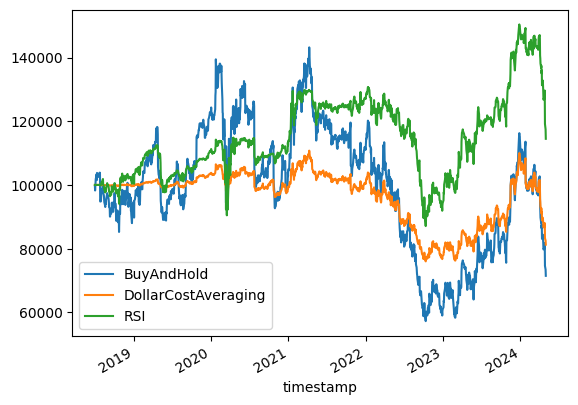

In [26]:
bt = cira.strategy.multi_strategy_backtest([cira.strategy.ByAndHold(), cira.strategy.DollarCostAveraging(1), strat], test_data, test_data["close"].to_frame(), 100_000)
print(f"Delta: {bt[strat.name].values[-1] - bt['BuyAndHold'].values[-1]:.2f}$")
print(f"DiffBH: {(bt[strat.name].values[-1] / bt['BuyAndHold'].values[-1])*100:.2f}%")
bt.plot()

<Axes: xlabel='timestamp'>

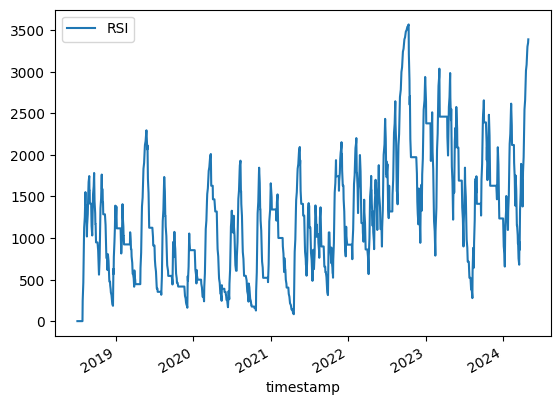

In [23]:
pd.DataFrame({strat.name:np.array(strat.allocation).cumsum()}, index=test_data.index[0:]).plot()